# 수치해석 프로젝트 - 20191600 박찬혁

### 1. 모멘텀(Momentum)이란?
> 기존의 SGD는 비등방성 함수에서는 비효율적인 움직임을 보여줄 때가 많다. 즉, 탐색 경로가 비효율적이다. 이를 해결하기 위해 고안된 방식이 모멘터(Momentum)이다. 모멘텀은 말 그대로 SGD 를 통해 이동하는 과정에 일종의 '관성’을 주는 것이다. 현재 Gradient를 통해 이동하는 방향과는 별개로, 과거에 이동했던 방식을 기억하면서 그 방향으로 일정 정도를 추가적으로 이동하는 방식이다. 수식으로 표현하면 다음과 같다. $v_t$를 time step $t$에서의 이동 벡터라고 할 때, 다음과 같은 식으로 이동을 표현할 수 있다. $$v_t=\gamma v_{t−1}+\eta \nabla_{\theta}J(\theta) $$ $$ \theta := \theta - v_t $$ $ \gamma $는 momentum의 정도를 주는 정도이며 보통 0.9를 사용한다고 한다.

### 2. Momentum 동작 코드 및 단위 테스트

#### 인공데이터를 활용한  1차원 회귀 구현

In [1]:
# 기본 모듈
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

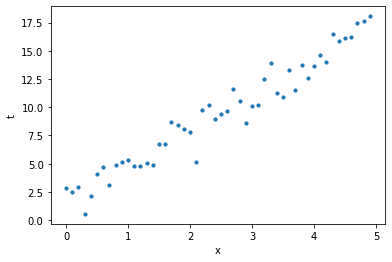

In [2]:
# 데이터 생성
np.random.seed(20)
X = np.arange(0, 5, 0.1)
T = 2 + 3 * X + np.random.randn(len(X))
plt.scatter(X, T, s=10)
plt.xlabel('x')
plt.ylabel('t')
plt.show()

#### tensorflow 모듈을 활용한 Momentum 동작 코드
tensorflow의 momentumOptimizer를 활용하여 선형회귀를 구현해보았다.

In [3]:
import tensorflow as tf

w0 = tf.Variable(2.0)
w1 = tf.Variable(3.0)


y = w0 * X + w1 # hypothesis function

cost = tf.reduce_mean(tf.square(y - T)) # mean square error 

a = tf.Variable(0.001) # learning rate
optimizer = tf.train.MomentumOptimizer(learning_rate=a,momentum=0.95)
train = optimizer.minimize(cost)

init = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init)

losses = []
for step in range(2000):
    sess.run(train)
    loss = sess.run(cost)
    losses.append(loss)
    if (step+1) % 100 == 0:
        print('step : ', (step+1), 'loss : ', loss, 'w0 : ',sess.run(w0), 'w1 : ',sess.run(w1))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
step :  100 loss :  1.3042307 w0 :  2.890637 w1 :  2.311773
step :  200 loss :  1.1957588 w0 :  3.0688913 w1 :  1.8894236
step :  300 loss :  1.1878866 w0 :  3.1107562 w1 :  1.7603792
step :  400 loss :  1.1872295 w0 :  3.1223755 w1 :  1.7228835
step :  500 loss :  1.1871746 w0 :  3.1257358 w1 :  1.7120556
step :  600 loss :  1.1871699 w0 :  3.1267095 w1 :  1.7089292
step :  700 loss :  1.1871696 w0 :  3.1269908 w1 :  1.7080269
step :  800 loss :  1.1871696 w0 :  3.1270719 w1 :  1.7077667
step :  900 loss :  1.1871697 w0 :  3.127096 w1 :  1.7076916
step :  1000 loss :  1.1871696 w0 :  3.1271017 w1 :  1.7076706
step :  1100 loss :  1.1871696 w0 :  3.1271033 w1 :  1.7076666
step :  1200 loss :  1.1871696 w0 :  3.1271033 w1 :  1.7076666
step :  1300 loss :  1.1871696 w0 :  3.1271033 w1 :  1.7076666
step :  1400 loss :  1.1871696 w0 :  3.1271033 w1 :  1.7076666
step :  1500 loss :  1.1871696 w0 :  3.1271033 w1 :  1.7

#### momentum의 성능 체크 : epoch에 따른 loss 그래프

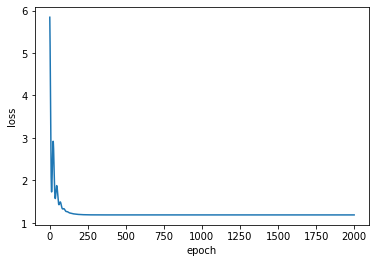

In [4]:
x = np.arange(1, 2001)
losses = np.array(losses)

plt.plot(x, losses)

plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

#### 회귀를 통해 예측한 그래프

3.1271033 1.7076666


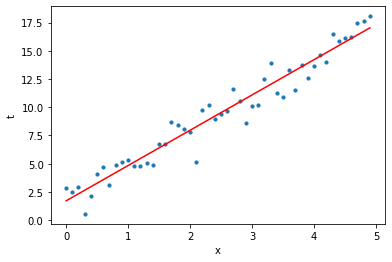

In [5]:
plt.scatter(X, T, s=10)
plt.plot(X, sess.run(w0) * X + sess.run(w1), color='r')
print(sess.run(w0), sess.run(w1))
plt.xlabel('x')
plt.ylabel('t')
plt.show()

### 3. Momentum의 구체화 작업

SGD class는 다음과 같이 정의하기로 한다.
* member variable
    * 학습률 lr
* member function
    * \__init__\(lr, momentum)
    > 생성자 함수로 lr, momentum을 설정한다.
    * get_mini_batch(X, T)
    > X, T의 mini_batch를 만들어주는 함수이다. SGD에서 확장된 optimizer이기 때문에, mini_batch는 꼭 만들어줘야 한다.
    * update(params, grads)
    > tf.train.MomentumOptimizer()에서 train메소드와 동일한 역할을 수행한다. 즉, params를 업데이트 한다. 업데이트 방식은 앞서 설명한 모멘텀의 방식을 따른다.

In [6]:
class Momentum:
    def __init__(self, lr=0.001, momentum=0.9): # 생성자
        self.lr = lr
        self.momentum = momentum
        self.v = [0, 0]
    def get_mini_batch(self, X, T):
        batch_size = len(X) // 10
        batch_mask = np.random.choice(len(X), batch_size)
        X_batch = X[batch_mask]
        T_batch = T[batch_mask]
        return X_batch, T_batch
    
    def update(self, params, grads):
        self.v[0] = self.momentum*self.v[0] - self.lr*grads[0]
        self.v[1] = self.momentum*self.v[1] - self.lr*grads[1]
        params[0] += self.v[0]
        params[1] += self.v[1]

### 4. momentum의 단위 테스트

#### 단위테스트 1. get_mini_batch()
> Momentum에서 mini_batch를 return해주는 get_mini_batch 메소드가 제대로 동작하는지 테스트 해보겠다. 잎서 활용한 인공데이터를 활용하여 테스트를 해보겠다.

In [7]:
optimizer = Momentum(lr=0.001, momentum=0.9) # 생성자

X_batch, T_batch = optimizer.get_mini_batch(X, T) # 테스트할 함수 X, T 인공데이터
print('X : ', X)
print('T : ', T)
print('the batch of X : ', X_batch)
print('the batch of T : ', T_batch)

X :  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9]
T :  [ 2.88389311  2.49586502  2.95753652  0.55673809  2.11516741  4.05969629
  4.73946935  3.12151896  4.90309684  5.10641447  5.32346101  4.80658912
  4.80798321  5.05763207  4.92049734  6.74571517  6.7558052   8.66763255
  8.45110868  8.10636843  7.8313539   5.11029721  9.72013226 10.23277821
  8.95666123  9.36996929  9.69098263 11.65618644 10.52877835  8.63305128
 10.11450685 10.19542052 12.53286635 13.959838   11.26506204 10.88700978
 13.32706972 11.54889926 13.72961334 12.56347346 13.6615094  14.62097078
 13.99769198 16.44472836 15.84703408 16.09321721 16.2380245  17.45778902
 17.60451128 18.05179619]
the batch of X :  [4.8 3.1 1.  3.8 0.9]
the batch of T :  [17.60451128 10.19542052  5.32346101 13.72961334  5.10641447]


#### 단위테스트 1. 실행결과 : 성공
> 결과는 성공적이었다. 실행 결과는 random이기에 실행 할 때마다 달라진다. mini_batch의 크기는 데이터의 크기가 작은 관계로 크기를 강제했으나 향후 커다란 데이터를 받을 때는 따로 parameter를 받아 나누어도 될 것이다.

#### 단위테스트 2. update()
> Momentum에서 weight을 업데이트 해주는 update 메소드에 대한 update 메소드에 대한 단위테스트를 해보겠다. gradient를 구하는 함수는 클래스 외부에서 구현을 하였다.

In [8]:
params = [1, 0]

def get_gradient(x, t, params): # griadents of weights
    y = params[0] * x + params[1]
    d_w0 = 2 * np.mean((y - t) * x)
    d_w1 = 2 * np.mean(y - t)
    grads = [d_w0, d_w1]
    return grads

print('before update : ', params)

grads = get_gradient(X, T, params)
print('gradients : ', grads)

optimizer = Momentum(lr=0.001, momentum=0.9)
optimizer.update(params, grads) # update
print('after update : ', params)

before update :  [1, 0]
gradients :  [-42.76282785474149, -13.838136469541514]
after update :  [1.0427628278547414, 0.013838136469541514]


#### 단위테스트 2. 실행결과 : 성공
> parameter가 성공적으로 update에 성공하였다.

#### 최종 테스트
> 각 단위에서 성공적으로 작동이 되는 것을 알았으니 이제 그 모듈들이 모여서 제대로 된 성능을 내는지 part 1, 2에서 사용했던 인공데이터들을 통해서 학습을 2000 에폭정도 학습을 시키고, 그 성능을 그래프로 표현해보겠다. loss를 구하는 함수는 외부에서 구현하였다.

In [9]:
params = [1, 0] # y = 1 * x  + 0

def get_loss(x, t, params): # mean square error function
    y = params[0] * x + params[1]
    return np.mean((y - t) ** 2)

def get_gradient(x, t, params): # griadents of weights
    y = params[0] * x + params[1]
    d_w0 = 2 * np.mean((y - t) * x)
    d_w1 = 2 * np.mean(y - t)
    return d_w0, d_w1

epochs = 2000 # 반복할 에폭의 수
optimizer = Momentum(lr=0.001, momentum=0.9)
losses = [] # loss값을 저장할 배열
for epoch in range(epochs):
    X_batch, T_batch = optimizer.get_mini_batch(X, T) # mini batch
    
    grads = []
    d_w0, d_w1 = get_gradient(X_batch, T_batch, params)
    grads.append(d_w0)
    grads.append(d_w1)
    optimizer.update(params, grads) # update
    loss = get_loss(X_batch, T_batch, params)
    losses.append(loss)
    if (epoch+1) % 100 == 0:
        print((epoch+1), "epoch loss : ",loss) # epoch마다 loss 출력

100 epoch loss :  0.45513041236885404
200 epoch loss :  4.750362142126479
300 epoch loss :  0.8237536733182024
400 epoch loss :  0.8976961266036476
500 epoch loss :  0.4829144832232191
600 epoch loss :  0.40305623575437605
700 epoch loss :  0.5358734900954215
800 epoch loss :  1.1533449299223961
900 epoch loss :  1.0900967675001507
1000 epoch loss :  1.0907871315836926
1100 epoch loss :  0.8265565084874025
1200 epoch loss :  0.43665105574894003
1300 epoch loss :  0.2106900831819823
1400 epoch loss :  1.5000733968241586
1500 epoch loss :  1.1953282617879655
1600 epoch loss :  0.9804339049589194
1700 epoch loss :  2.5289120342338207
1800 epoch loss :  0.6768539687924012
1900 epoch loss :  1.0581418957489177
2000 epoch loss :  0.5747310200524256


#### 직접 구현한 momentum의 성능 : epoch에 따른 loss의 그래프

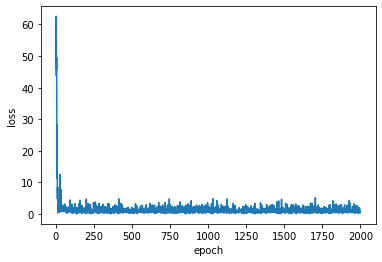

In [10]:
x = np.arange(1, epochs+1)
losses = np.array(losses)

plt.plot(x, losses)

plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

#### 직접 구현한 momentum의 성능 : 실제 값들과 비교

[3.1463521812957906, 1.7489787204552227]


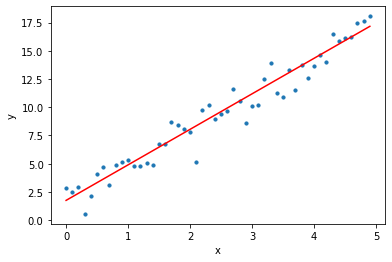

In [11]:
print(params) # 최종적으로 예측한 parameter y = w0 * x + w1
y = params[0] * X + params[1]

plt.scatter(X, T, s=10)
plt.plot(X, y, color='r')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### 최종 테스트 결과 : 성공적
> tensorflow 라이브러리로 구현한 optimizer와 성능이 상당히 비슷하게 나왔다. loss도 안정적으로 떨어지는 양상을 보였기에, 결과는 성공적이라고 볼 수 있다.

### 5. 로젠브록 함수를 활용한 모멘텀의 검증
> 최종적으로 로젠브록 함수를 통해 모멘텀이 성공적으로 수렴하는지에 대해 검증해보겠다.

#### rosenbrock 함수 및 도함수

In [12]:
def rosen(x, y):
    return (1 - x)**2 + 100.0 * (y - x**2)**2

def drosen(x, y):
    return np.array((2.0 * (x - 1) - 400.0 * x * (y - x**2), 200.0 * (y - x**2)))

#### momentum optimizer를 활용한 parameter의 갱신 경로 표시

1.021377251043591 1.021377251043591


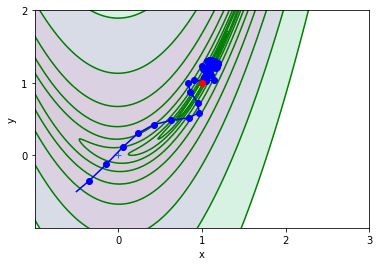

In [13]:
xx = np.linspace(-4, 4, 800)
yy = np.linspace(-3, 3, 600)
X, Y = np.meshgrid(xx, yy)
Z = rosen(X, Y)
level = np.logspace(-1, 3, 10)
plt.contourf(X, Y, Z, alpha=0.2, levels=level)
plt.contour(X, Y, Z, colors='green', levels=level)
plt.plot(0, 0, marker='+')

# momentum optimizer
optimizer = Momentum(lr=0.001, momentum=0.9)
params = [-0.5, -0.5] # initial parameter

itr = 500 # iteration count

# parameter 기록
x_arr = np.zeros(itr) # parameter의 x좌표의 움직임 기록
y_arr = np.zeros(itr) # parameter의 y좌표의 움직임 기록
x_arr[0] = params[0]
y_arr[0] = params[1]
for i in range(1, itr):
    grads = drosen(params[0], params[1])
    optimizer.update(params, grads)
    x_arr[i] = params[0]
    y_arr[i] = params[1]
    plt.plot(params[0], params[1], 'bo')

# 최종 목적지 체크
print(x_arr[itr-1], x_arr[itr-1]) 

plt.plot(x_arr, y_arr, 'b')
plt.plot(1, 1,'ro')
plt.xlim(-1, 3)
plt.ylim(-1, 2)
plt.xticks(np.linspace(0, 3, 4))
plt.yticks(np.linspace(0, 2, 3))
plt.xlabel("x")
plt.ylabel("y")
plt.show()

#### 최종 결과 : 성공적으로 최솟값 (1, 1)에 근접
> rosenbrock 함수같은 비등방성 함수에서는 발산하는 경우가 많으므로 조심해야 한다. 그러나, momentum optimizer 는 momentum=0.9, 학습률=0.001에서 발산하지 않고 500번 만에 최솟값 1,1에 접근하는데 성공했다.